In [2]:
%pip install keras_tuner scipy seaborn --quiet

import keras_tuner
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.stats import zscore

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


## Data Preprocessing

In [3]:
seed = 7
df = pd.read_csv('https://media.githubusercontent.com/media/MadMoose02/COMP3608-Project/main/card_transdata.csv')
# df = pd.read_csv('card_transdata.csv')

print(f'Shape of Dataframe: {df.shape}')

Shape of Dataframe: (1000000, 8)


In [4]:
df.head(5)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


## Initial Visualisations of Dataset

#### Boxplot

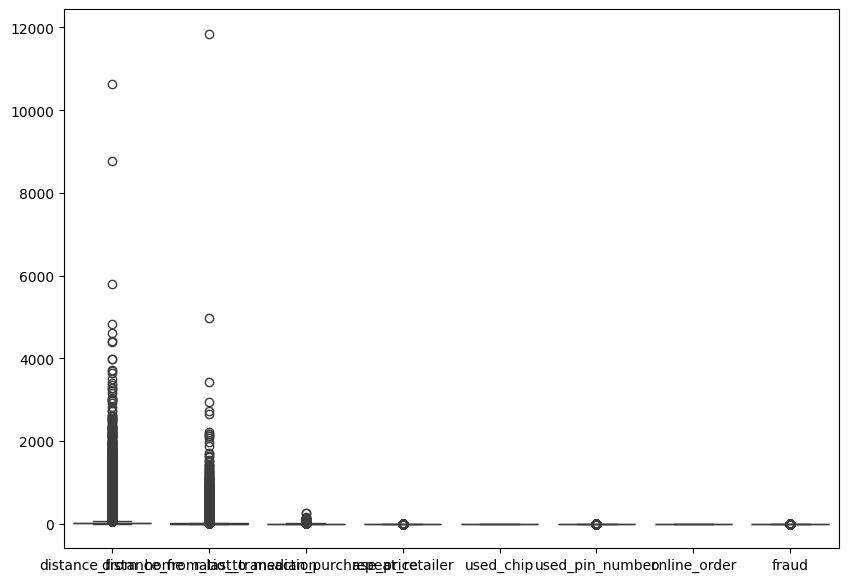

In [5]:
plt.figure(figsize=(10, 7))
sns.boxplot(df)
plt.show()

#### Correlation Matrix Heatmap

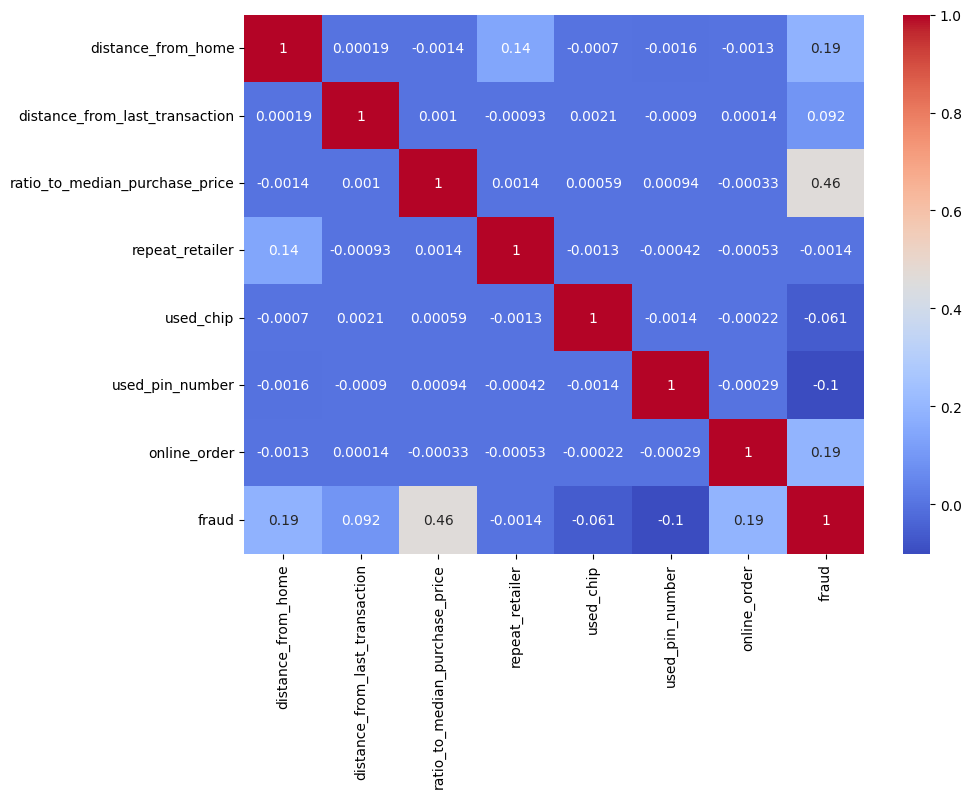

In [6]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Pairplot

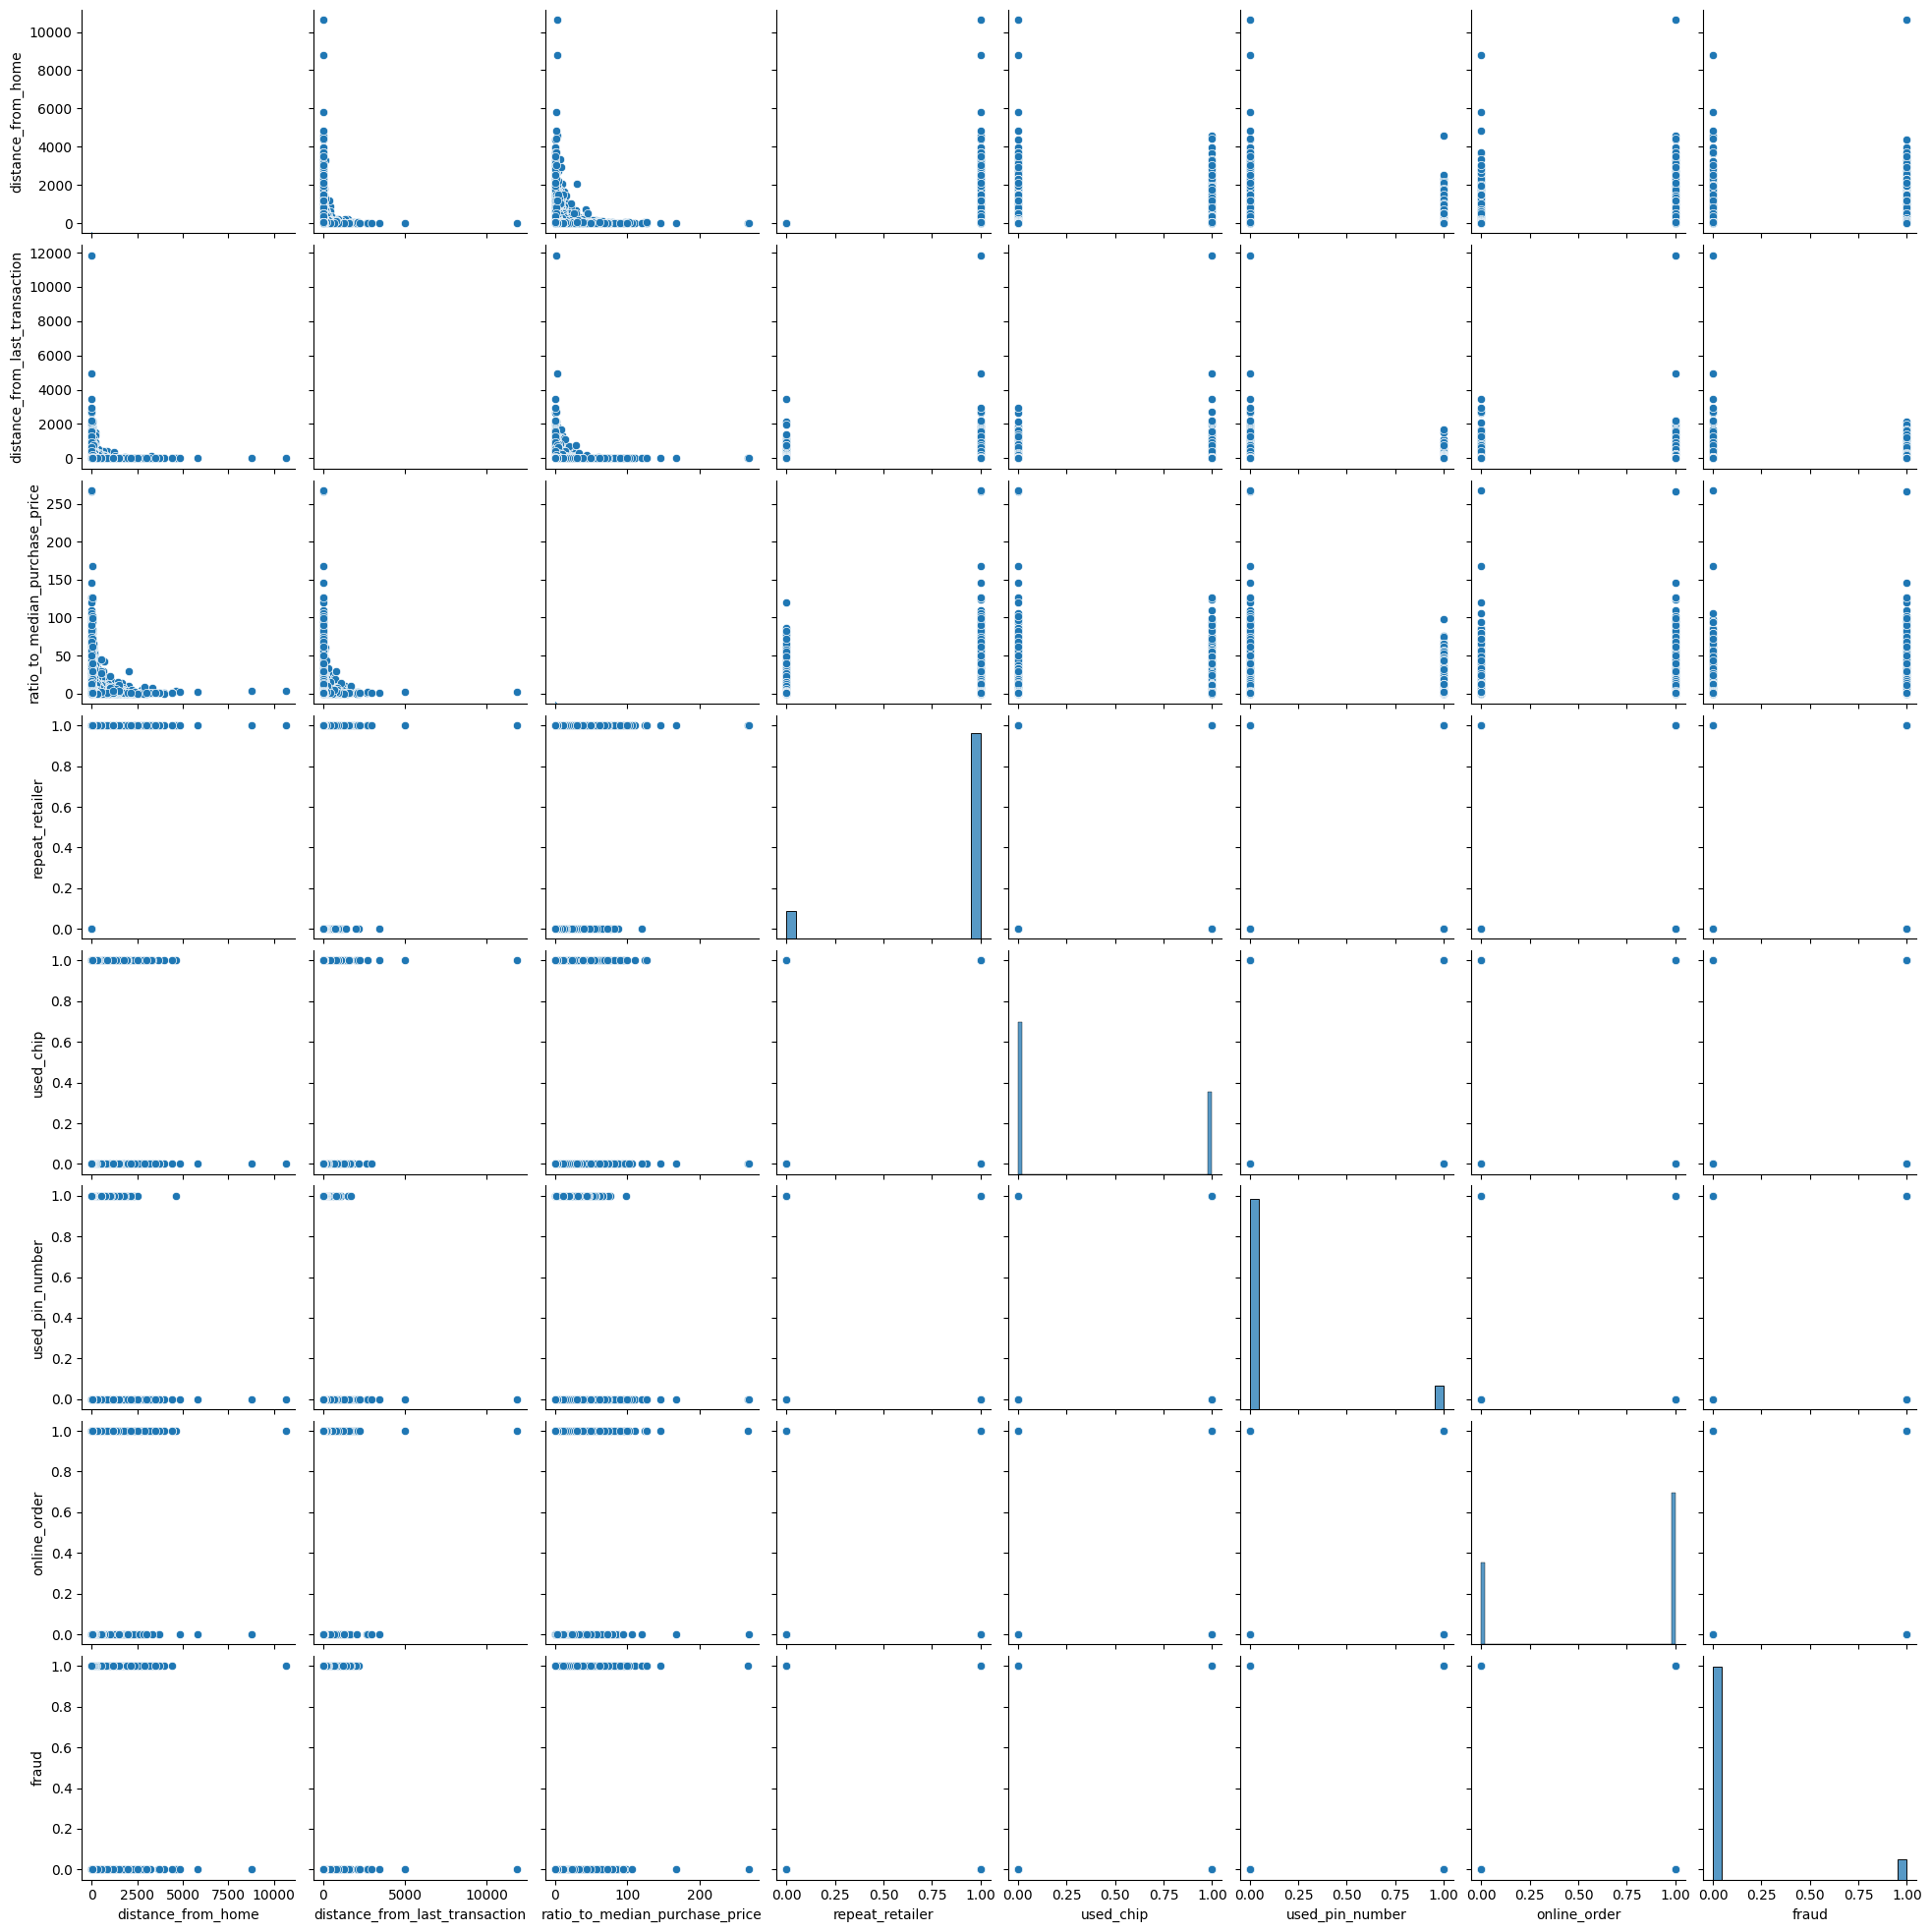

In [8]:
sns.pairplot(df)
plt.show()

## Data Cleaning

In [5]:
def plot_attribute_graphs(df, attribute):
    features = df.columns.drop(attribute)
    fig, axs = plt.subplots(len(features), figsize=(14, 4*len(features)))

    for i, feature in enumerate(features):
        axs[i].scatter(df[attribute], df[feature])
        axs[i].set_xlabel(attribute)
        axs[i].set_ylabel(feature)
        axs[i].set_title(f'{feature} vs. {attribute}', fontsize=15)

    plt.tight_layout()
    plt.show()

def plot_attribute_outlier_graphs(df, attribute):
    features = df.columns.drop([attribute, 'z_score_' + attribute, 'colour', 'size'])
    fig, axs = plt.subplots(len(features), figsize=(14, 4*len(features)))

    for i, feature in enumerate(features):
        axs[i].scatter(df[attribute], df[feature], c=df['colour'], s=df['size'])
        axs[i].set_xlabel(attribute)
        axs[i].set_ylabel(feature)
        axs[i].set_title(f'{feature} vs. {attribute}', fontsize=15)

    plt.tight_layout()
    plt.show()

def generate_zscore(df, attribute, threshold):
    df['z_score_' + attribute] = zscore(df[attribute])
    df['colour'] = df['z_score_' + attribute].apply(lambda x: 'red' if x > threshold else 'blue')
    df['size'] = df['z_score_' + attribute].apply(lambda x: 40 if x > threshold else 20)
    outliers = df[df['z_score_' + attribute].abs() > threshold]
    print(f'Found {len(outliers)} outliers')

def remove_outliers(df, attribute, threshold):
    df = df[df['z_score_' + attribute].abs() <= threshold]
    df = df.drop(['z_score_' + attribute, 'colour', 'size'], axis=1)
    return df

### Distance from Home

Found 72 outliers


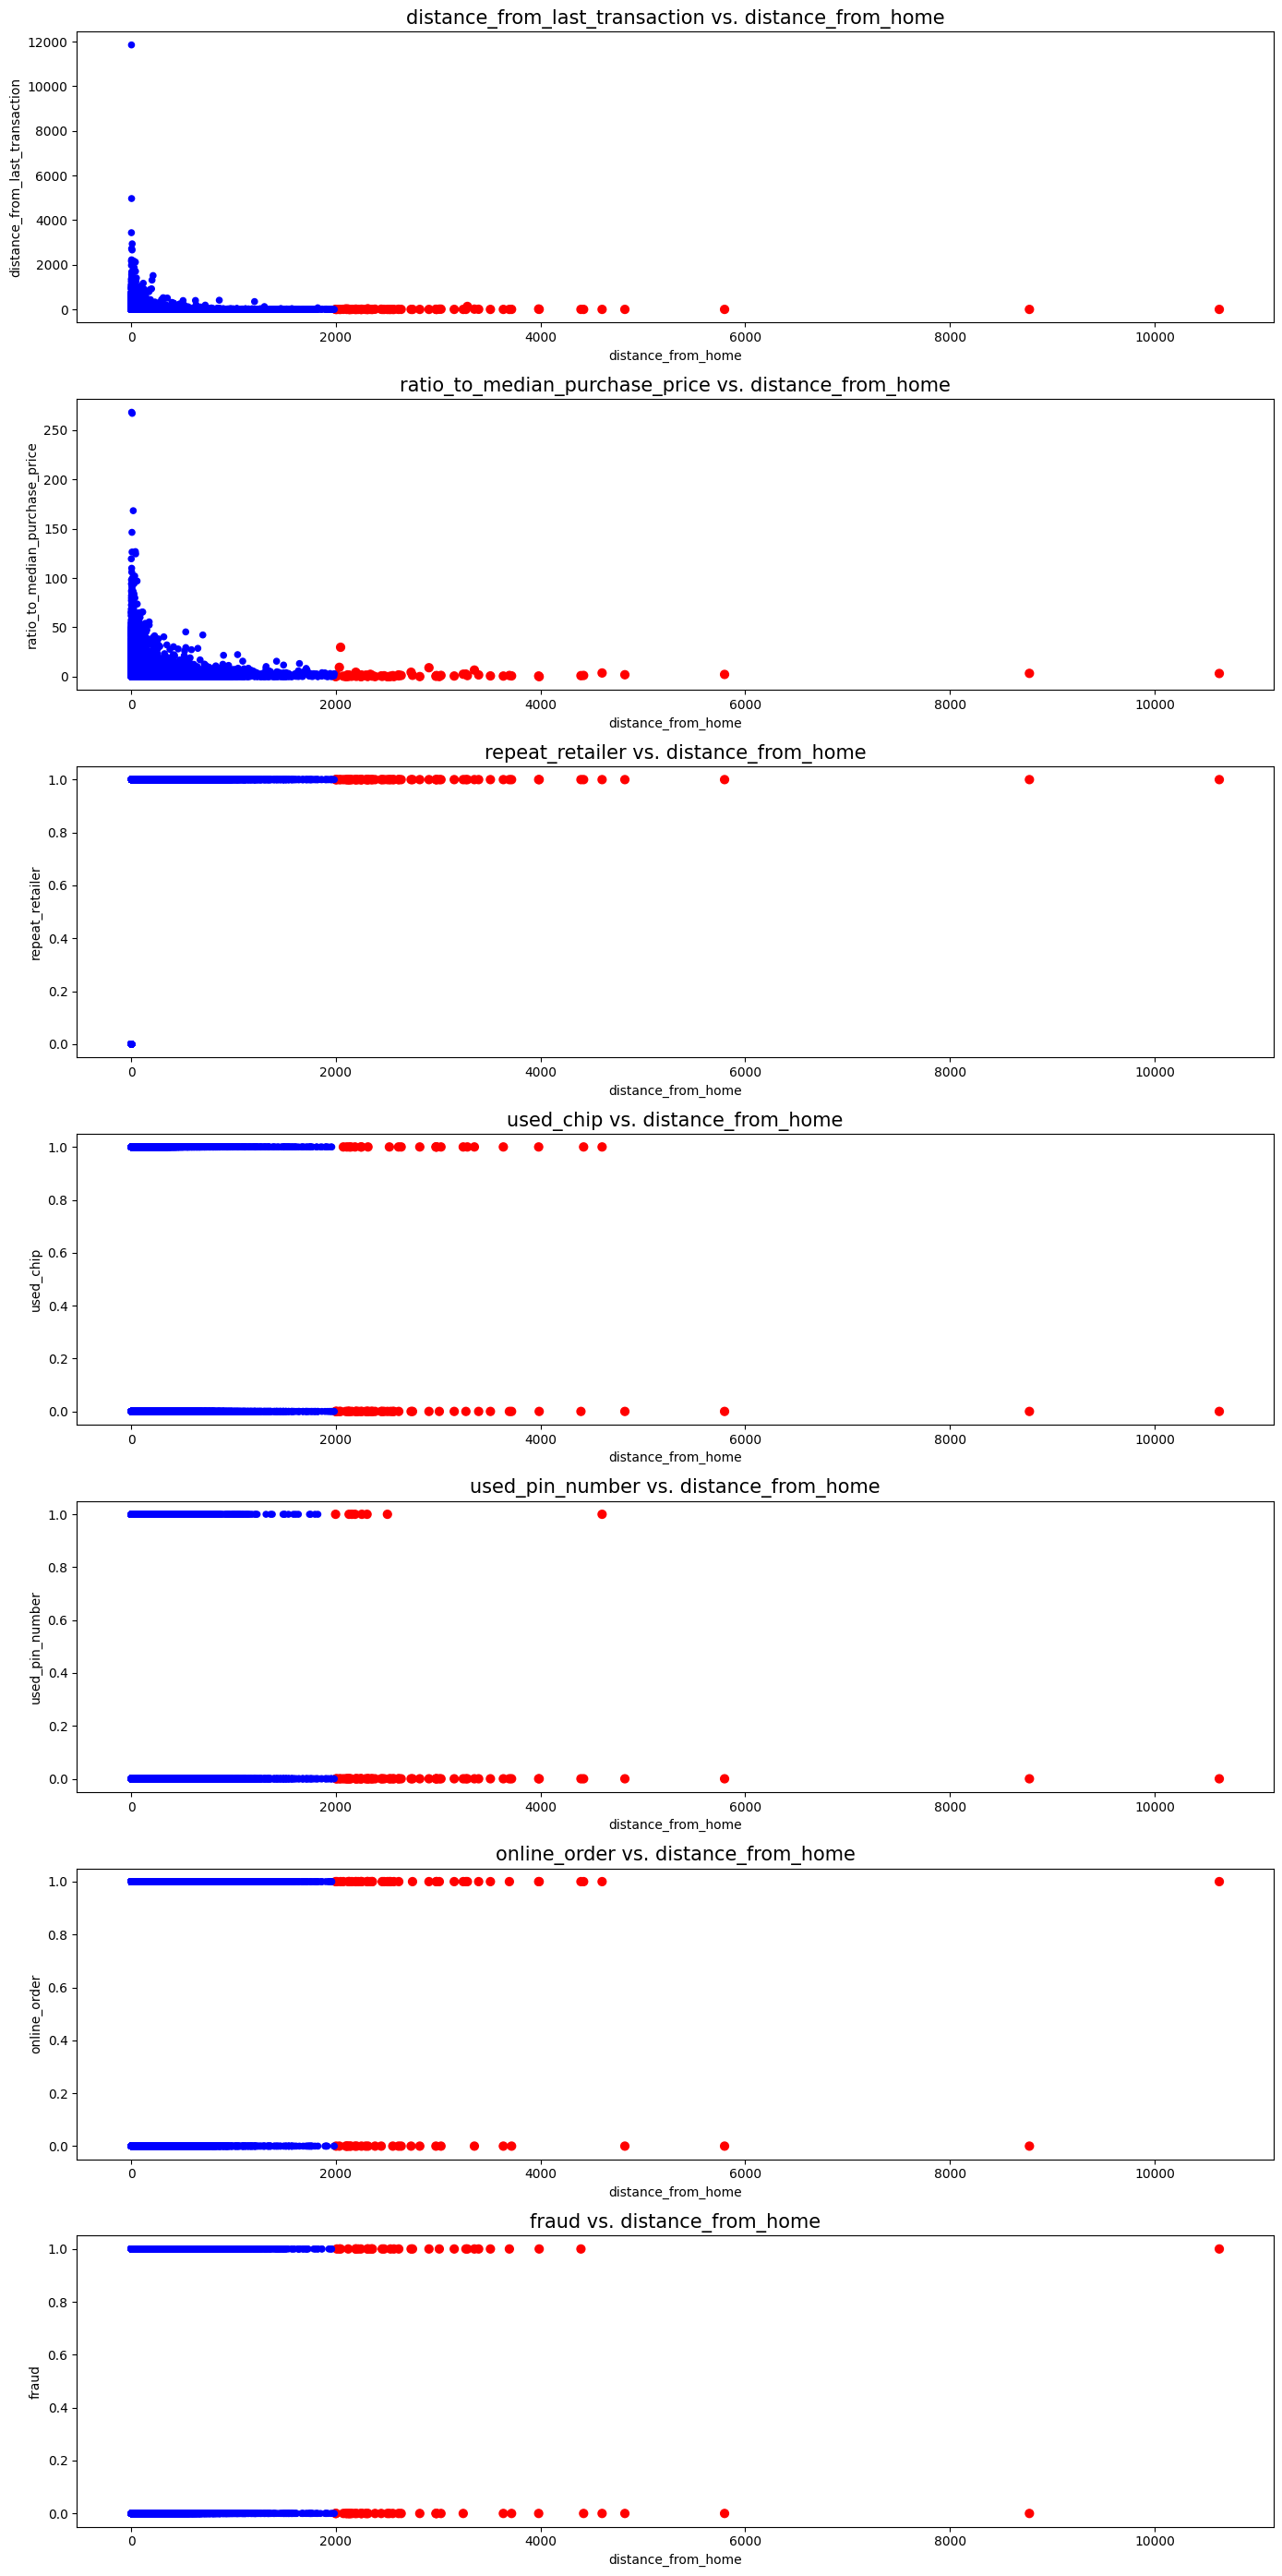

In [6]:
threshold = 30
attribute = 'distance_from_home'
generate_zscore(df, attribute, threshold)
plot_attribute_outlier_graphs(df, attribute)

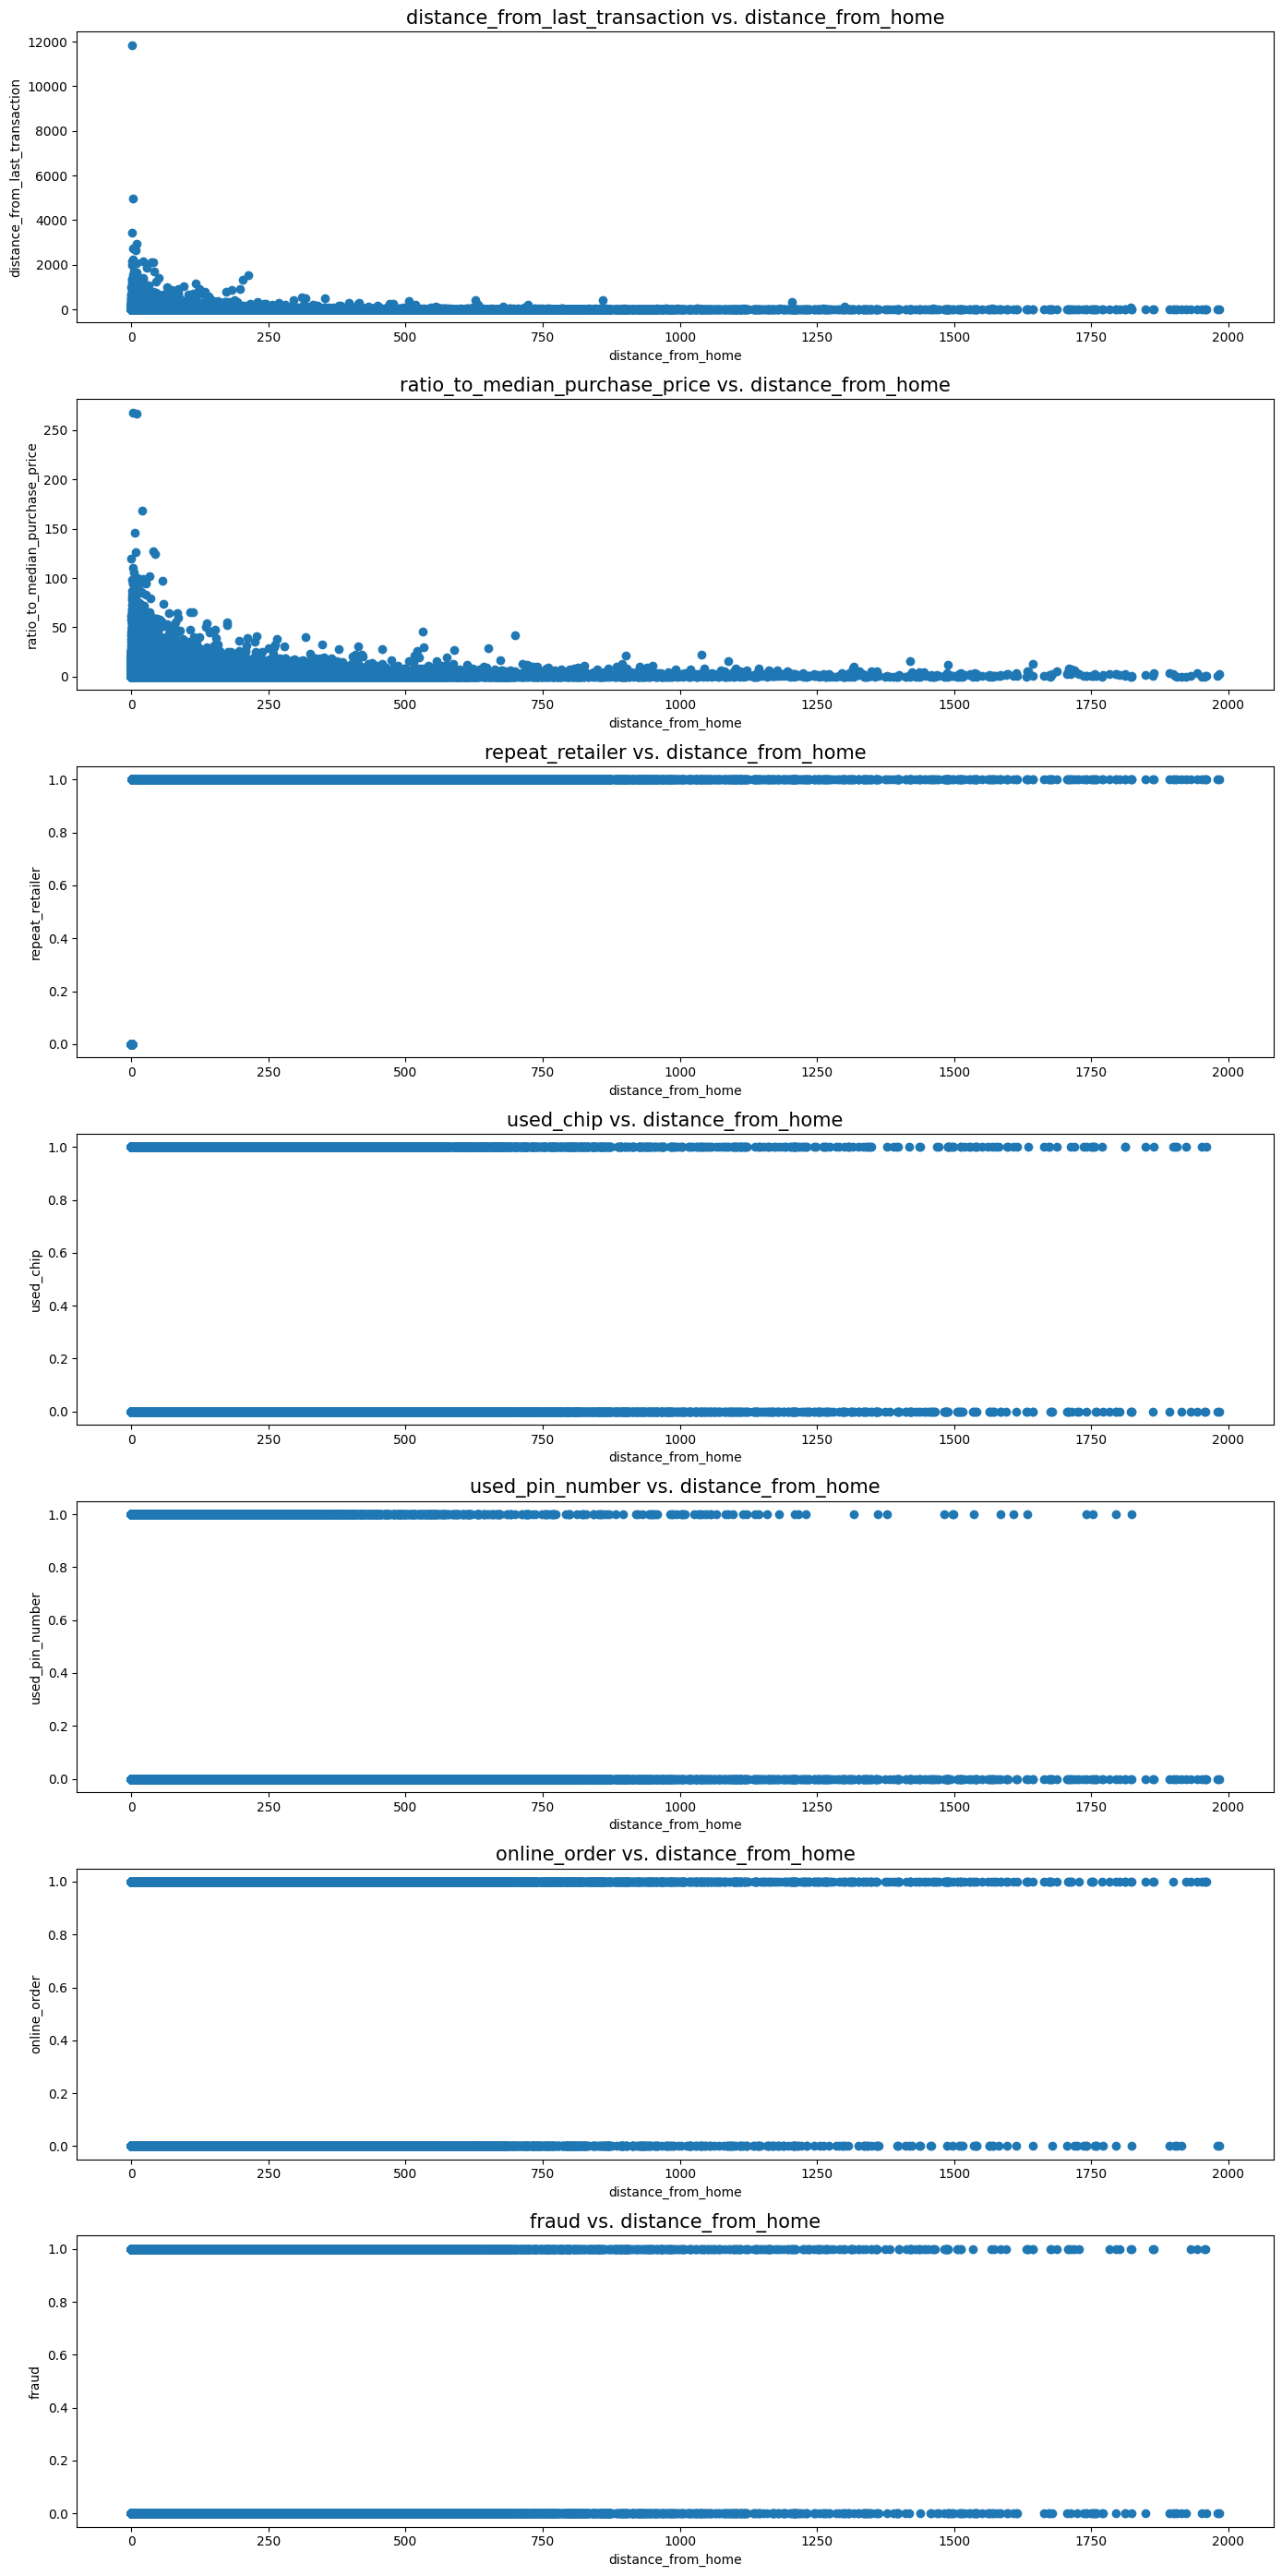

In [7]:
df = remove_outliers(df, attribute, threshold)
plot_attribute_graphs(df, attribute)

### Distance from Last Transaction

Found 100 outliers


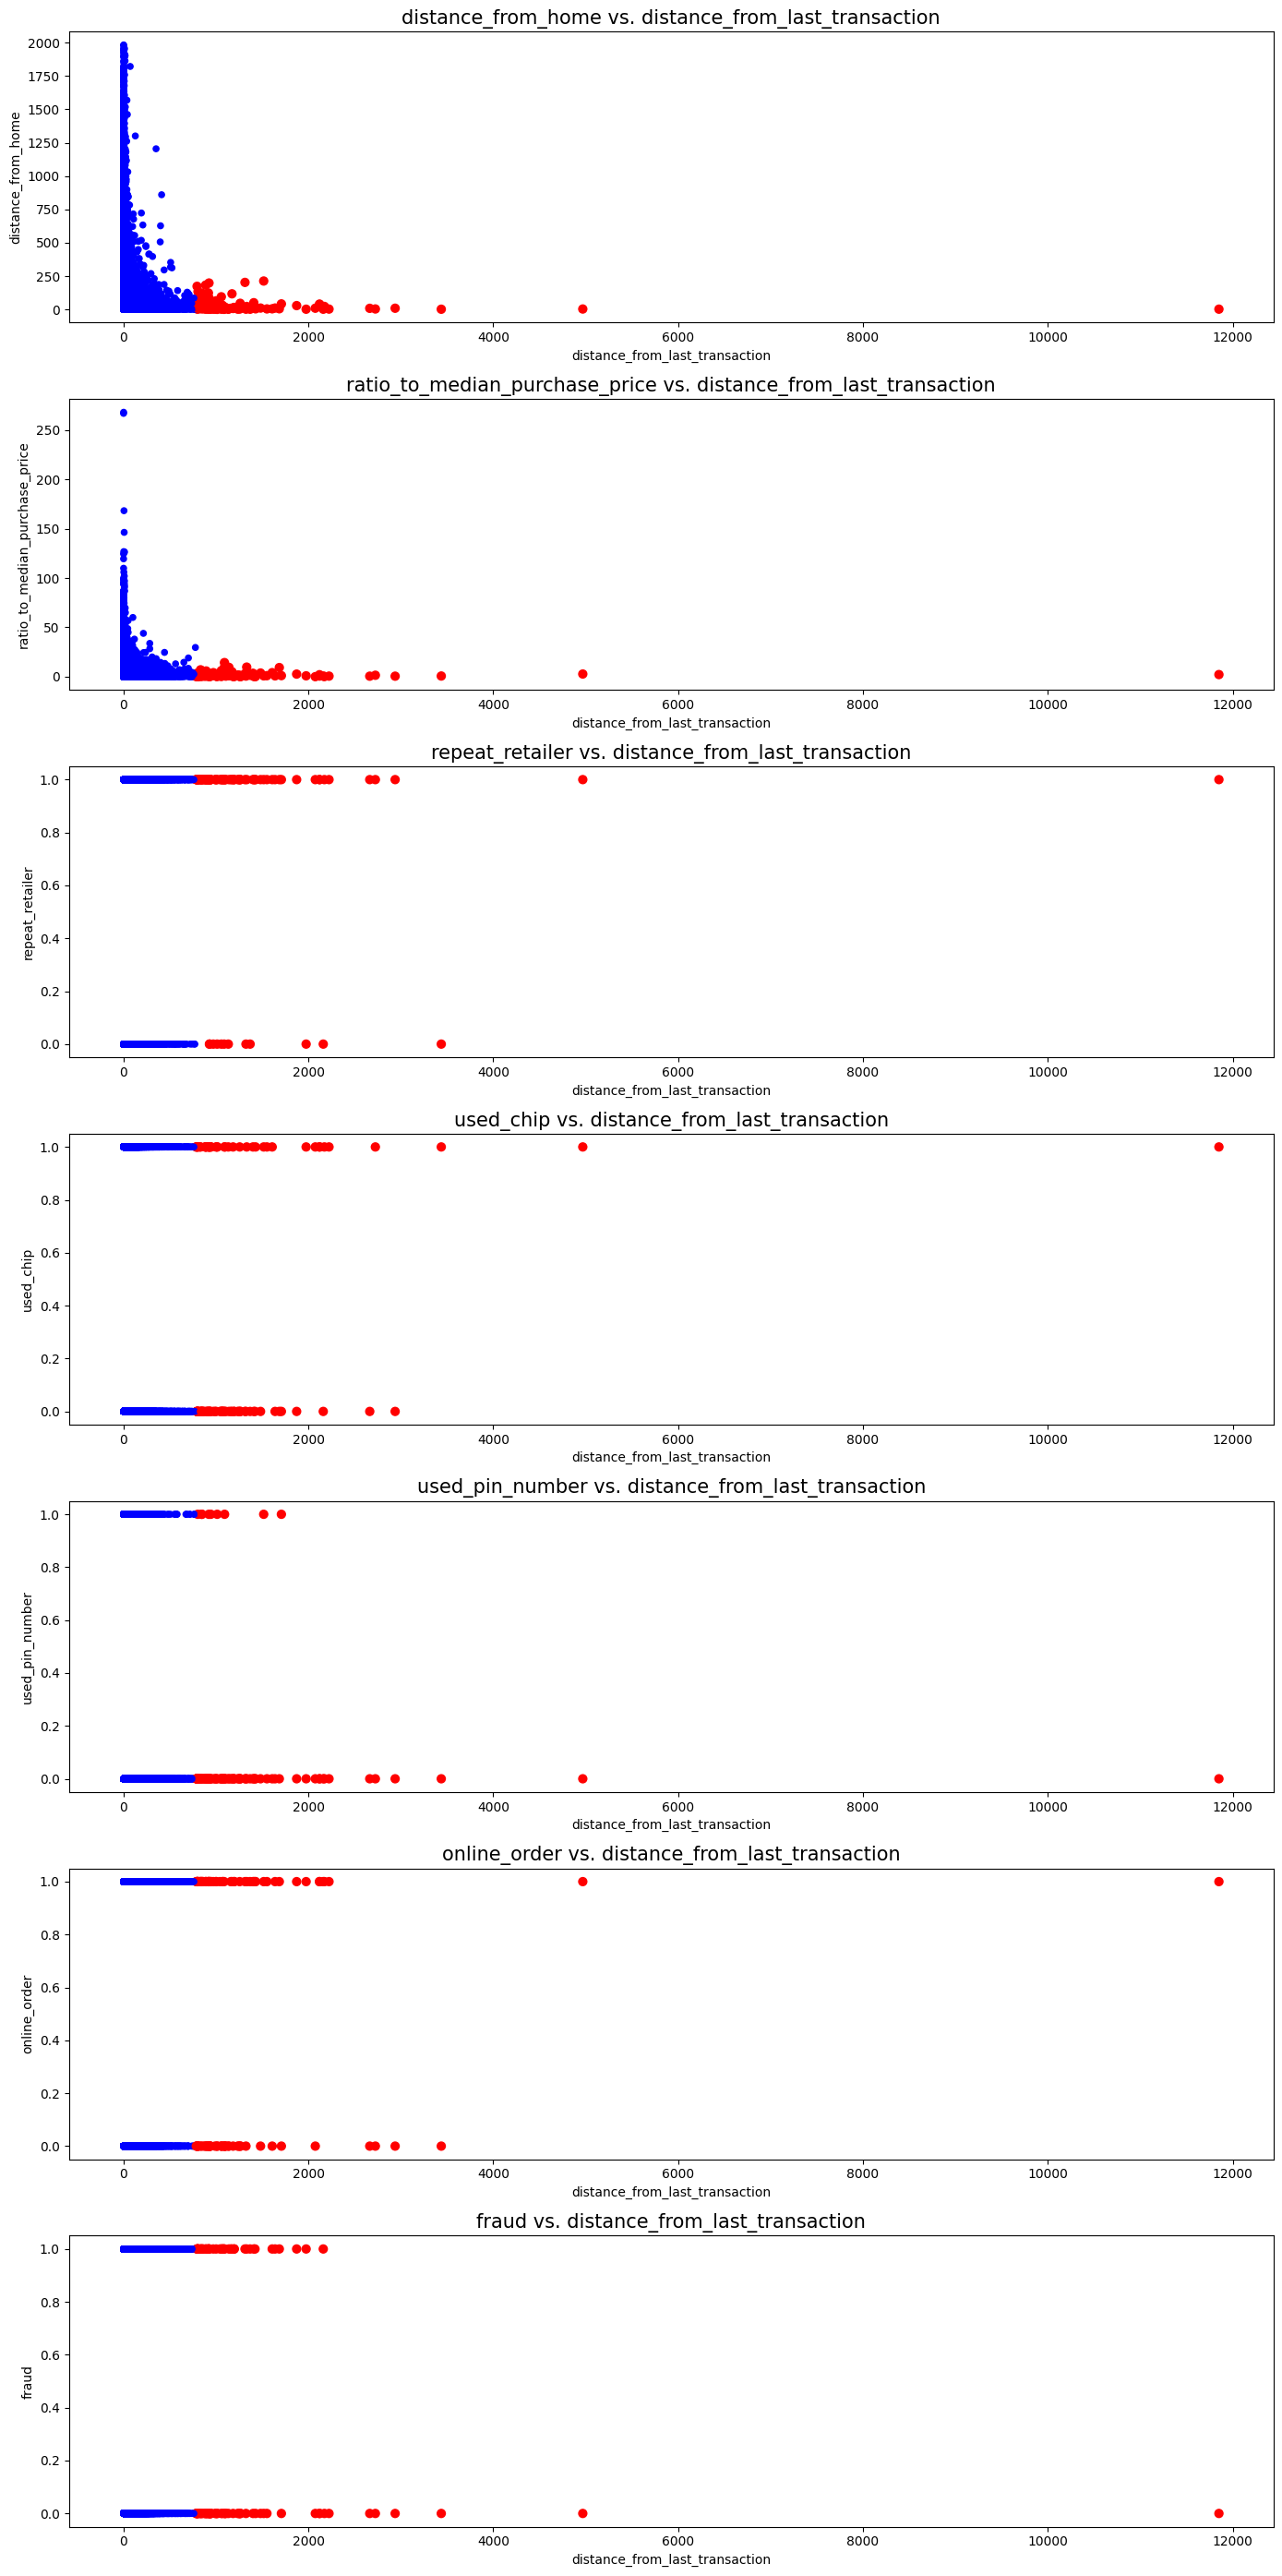

In [ ]:
threshold = 30
attribute = 'distance_from_last_transaction'
generate_zscore(df, attribute, threshold)
plot_attribute_outlier_graphs(df, attribute)

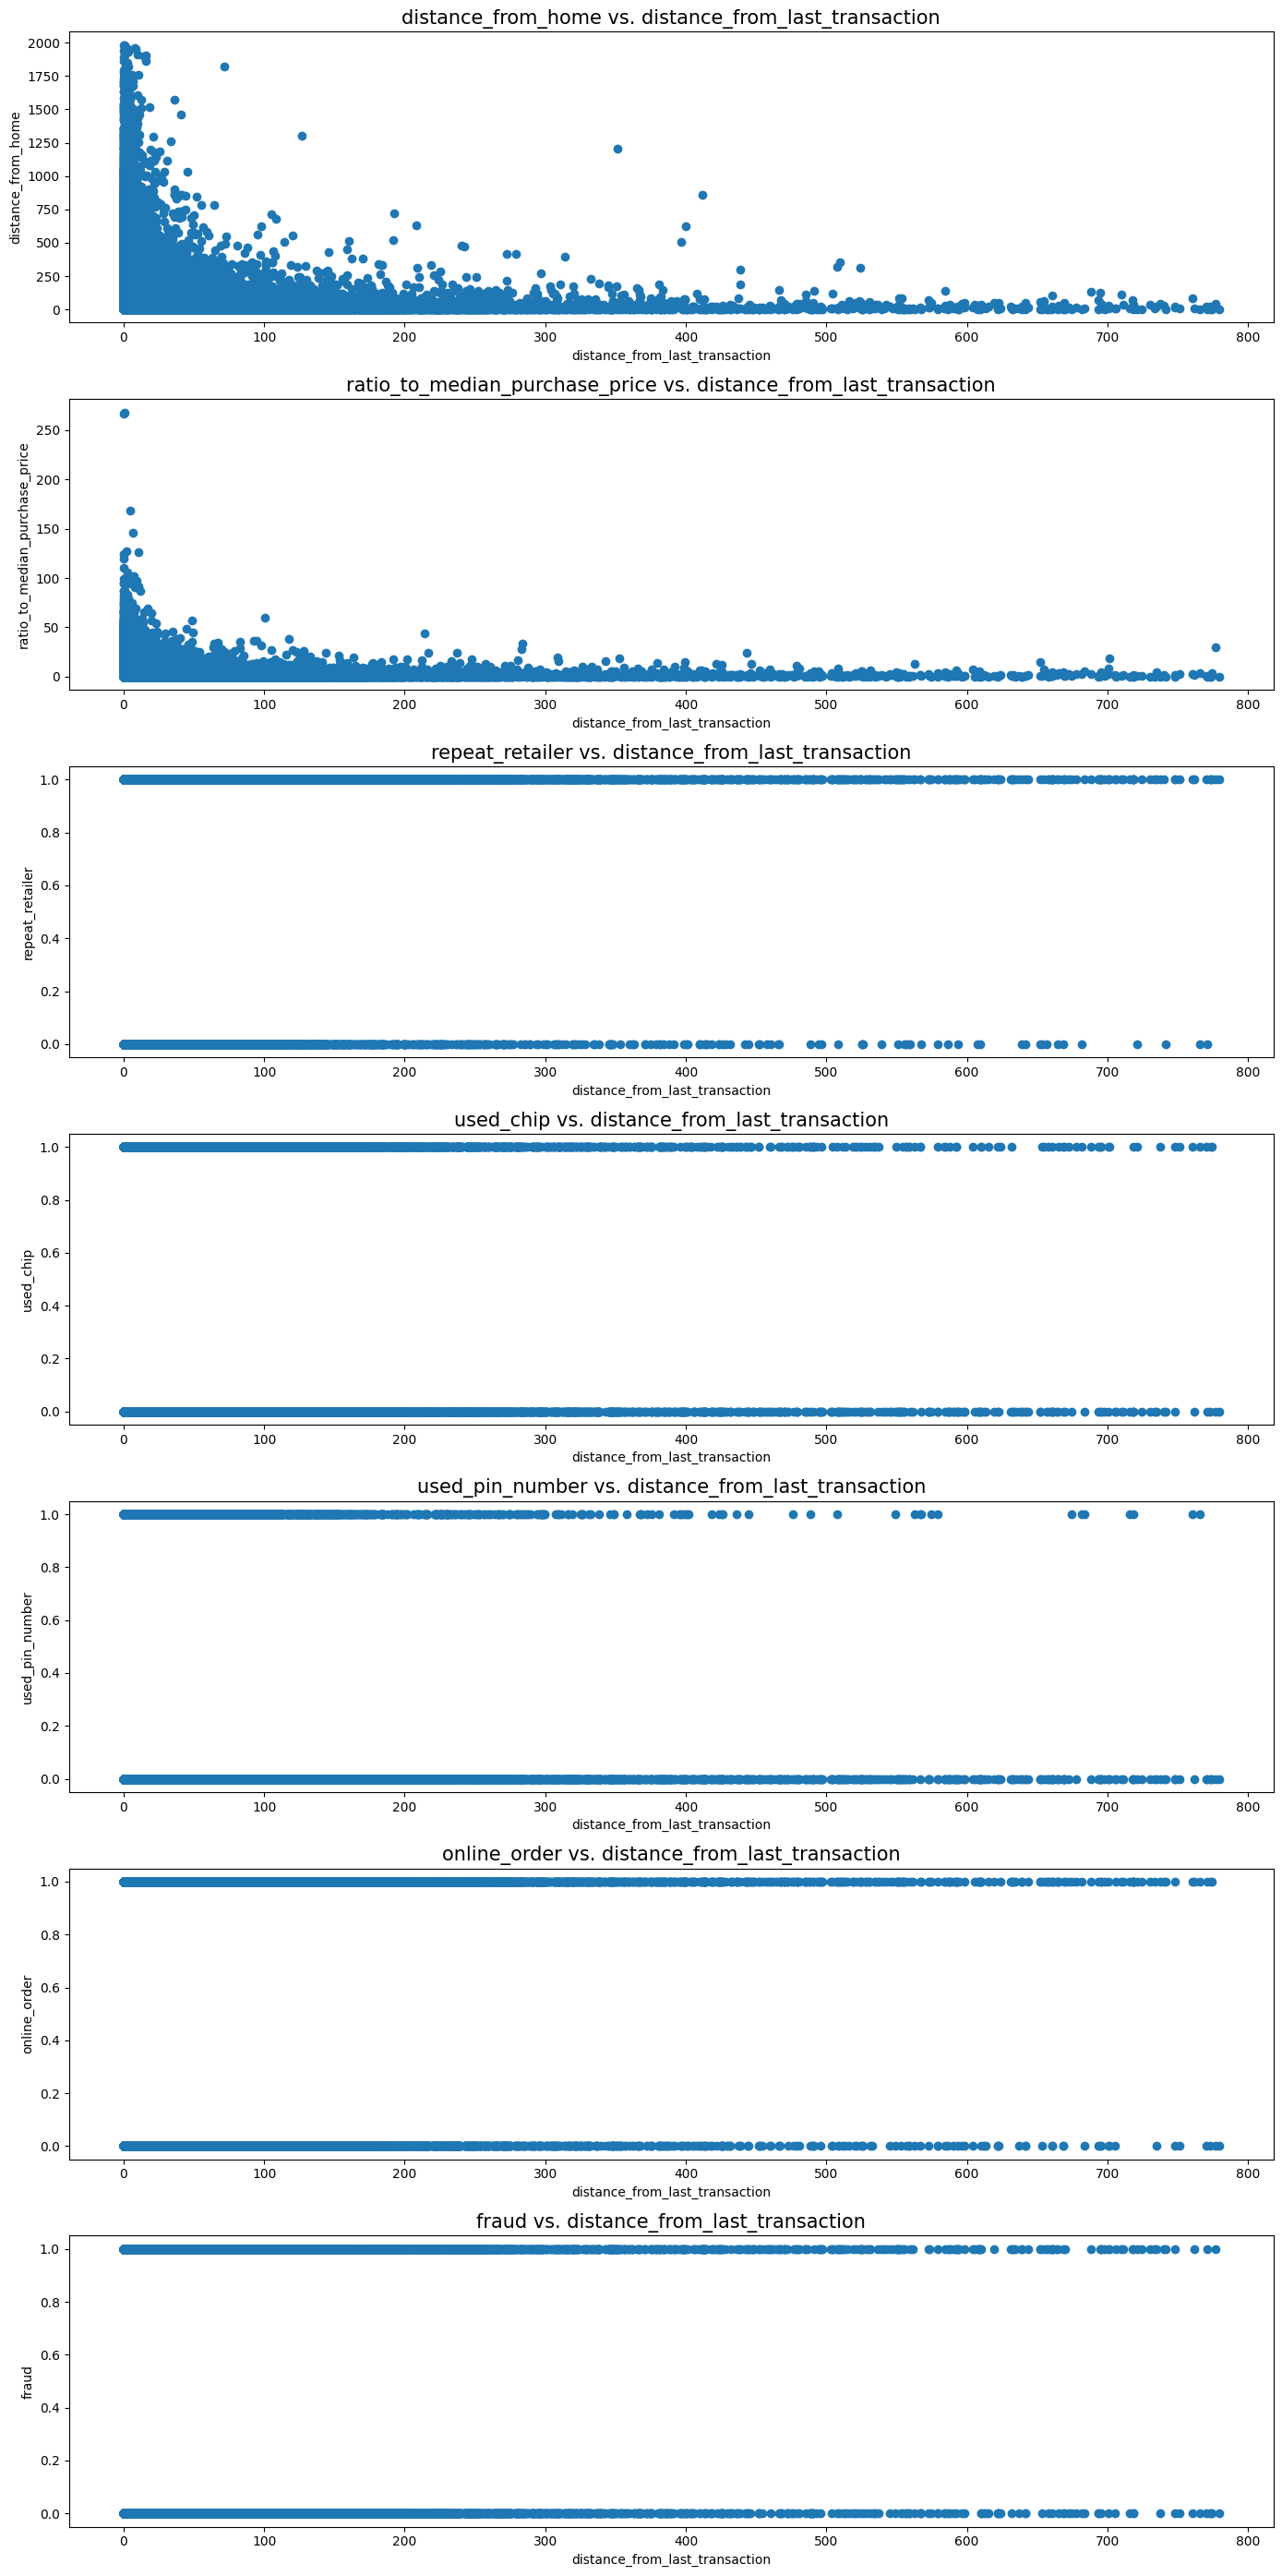

In [ ]:
df = remove_outliers(df, attribute, threshold)
plot_attribute_graphs(df, attribute)

### Ratio to Median Purchase Price

Found 48 outliers


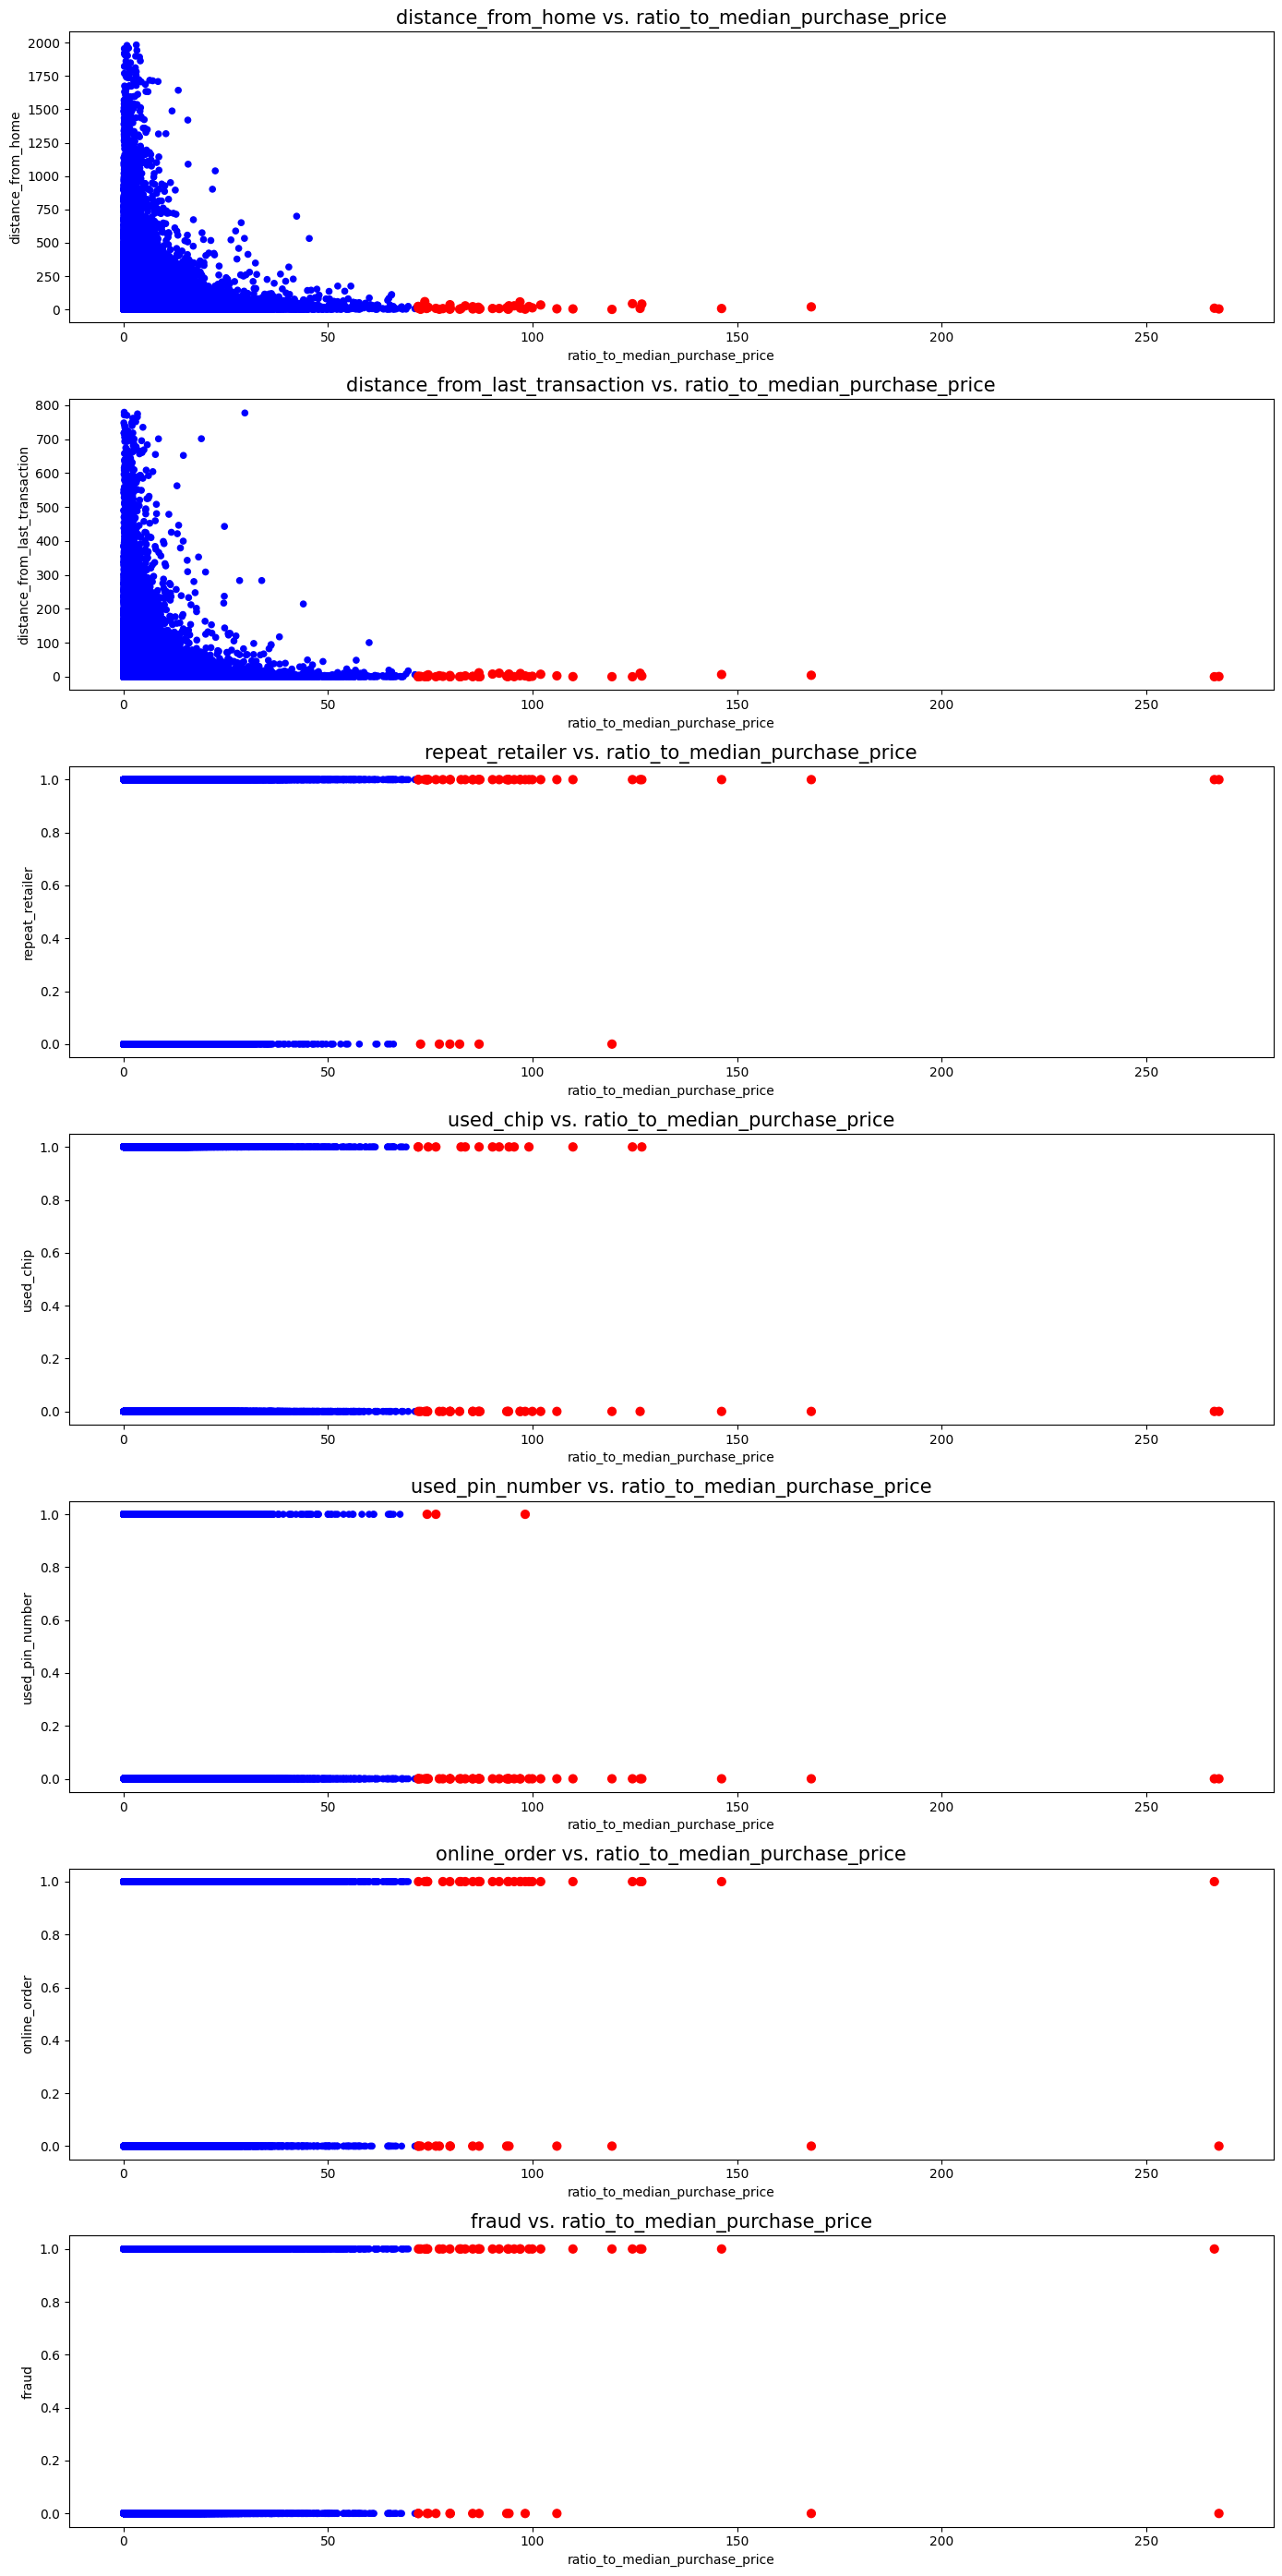

In [ ]:
threshold = 25
attribute = 'ratio_to_median_purchase_price'
generate_zscore(df, attribute, threshold)
plot_attribute_outlier_graphs(df, attribute)

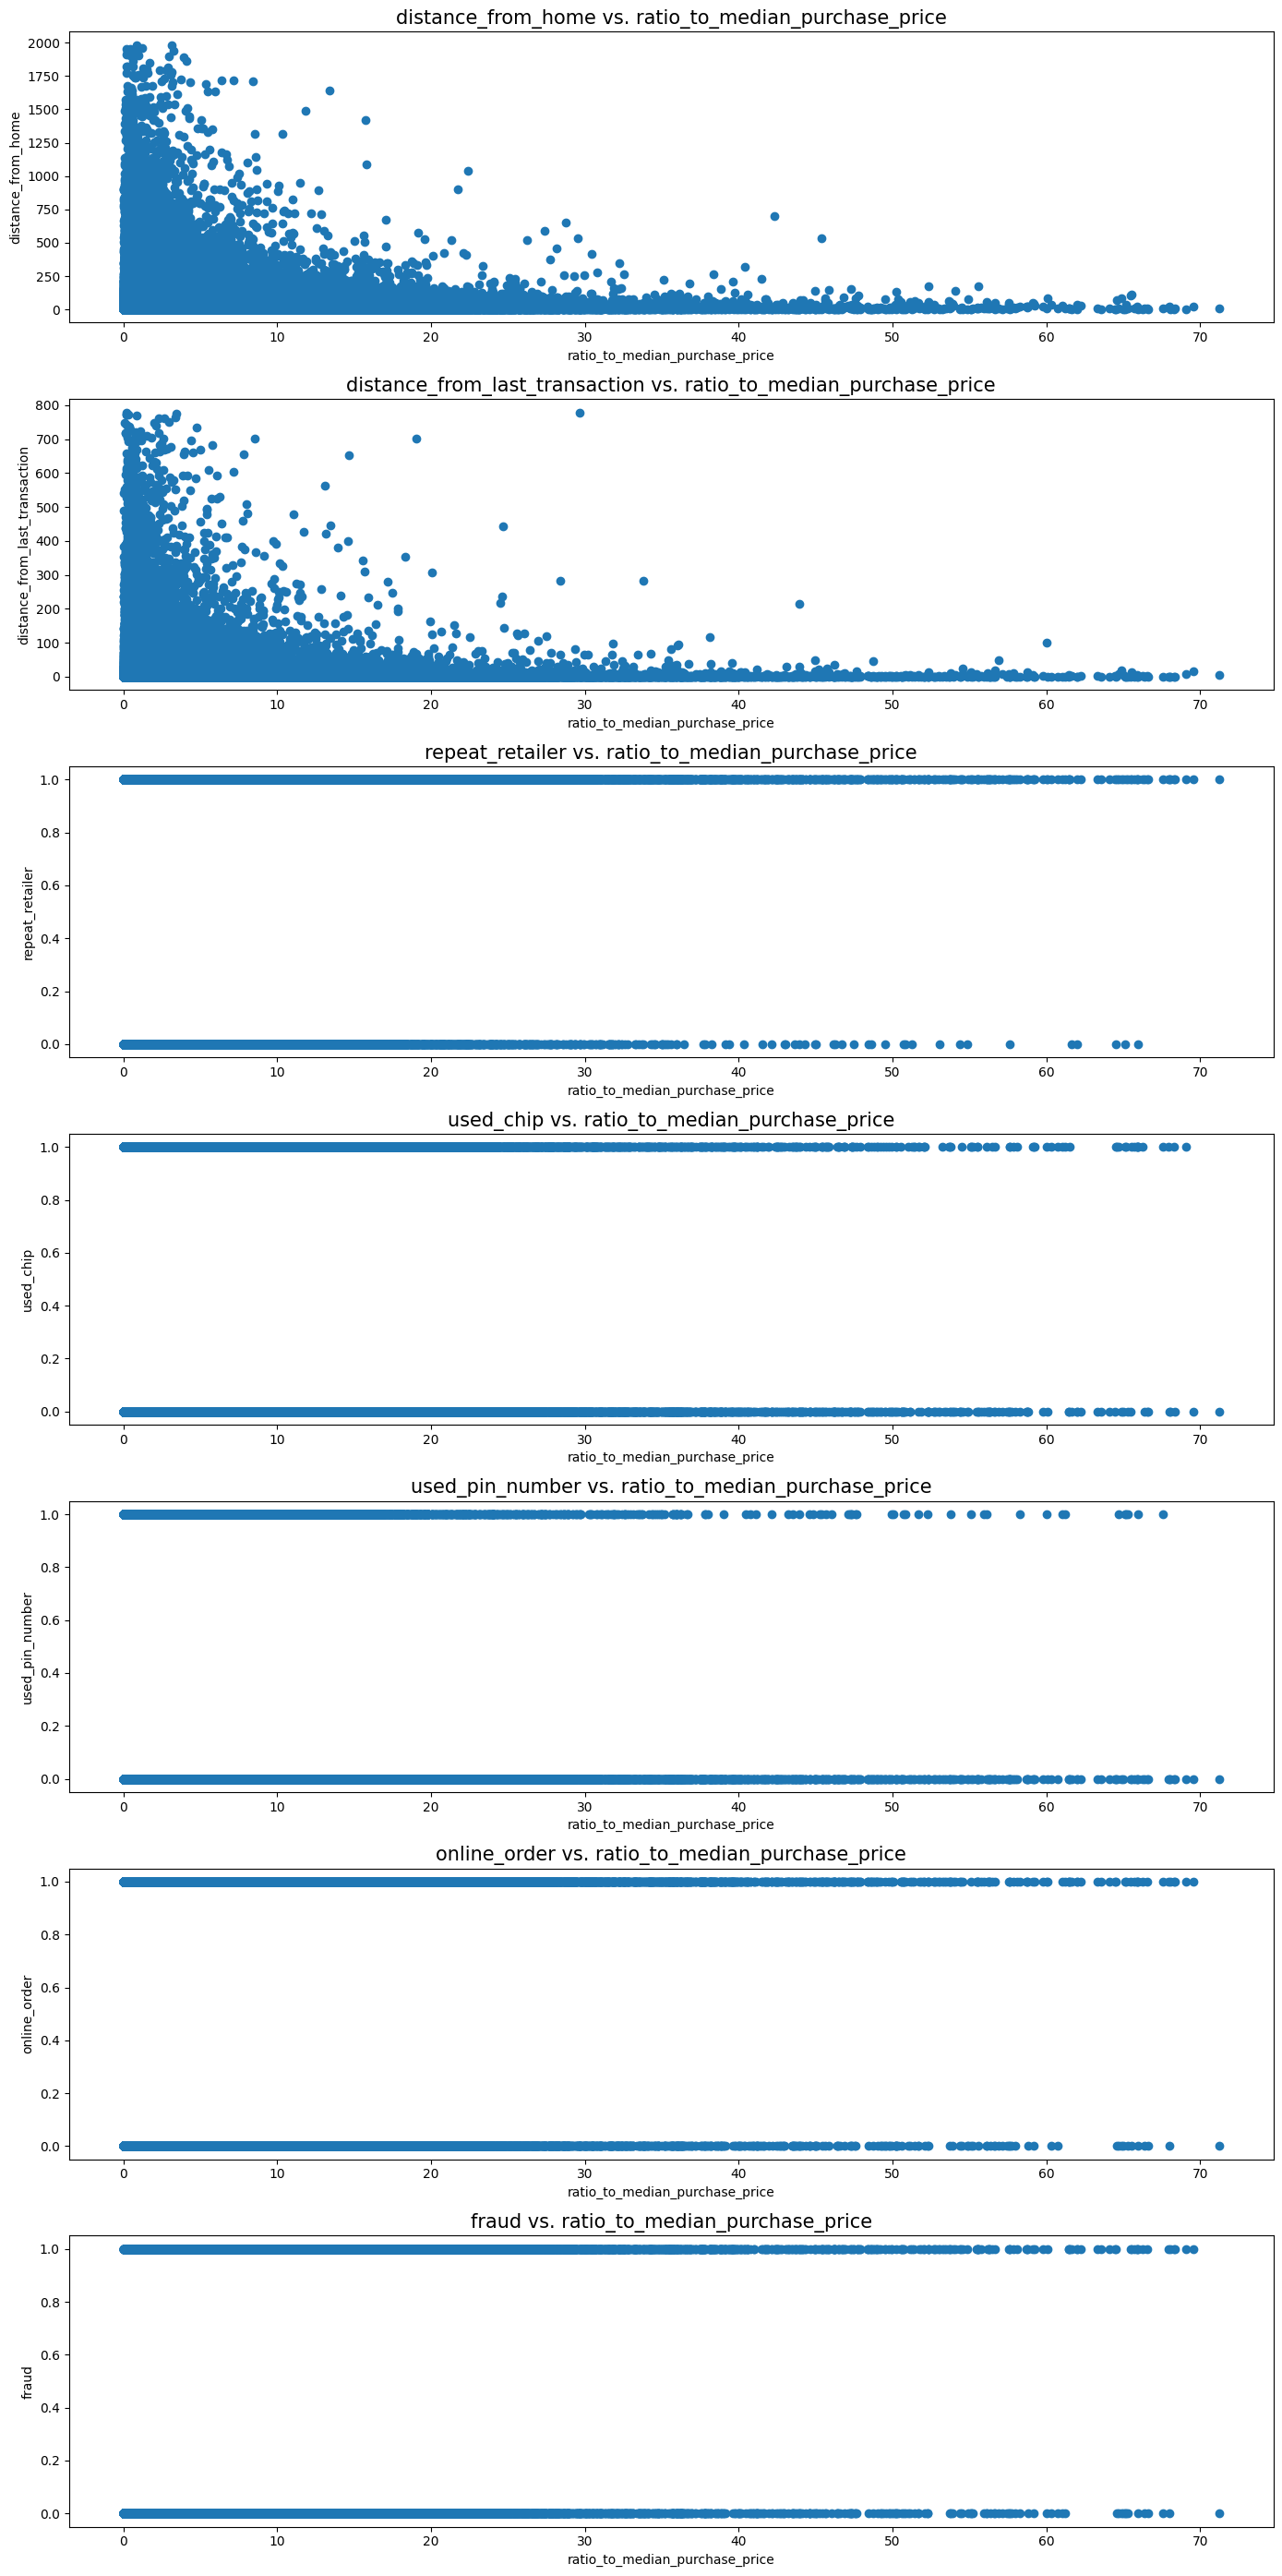

In [ ]:
df = remove_outliers(df, attribute, threshold)
plot_attribute_graphs(df, attribute)

### Final Visualisation of Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999780 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_home              999780 non-null  float64
 1   distance_from_last_transaction  999780 non-null  float64
 2   ratio_to_median_purchase_price  999780 non-null  float64
 3   repeat_retailer                 999780 non-null  float64
 4   used_chip                       999780 non-null  float64
 5   used_pin_number                 999780 non-null  float64
 6   online_order                    999780 non-null  float64
 7   fraud                           999780 non-null  float64
dtypes: float64(8)
memory usage: 68.6 MB


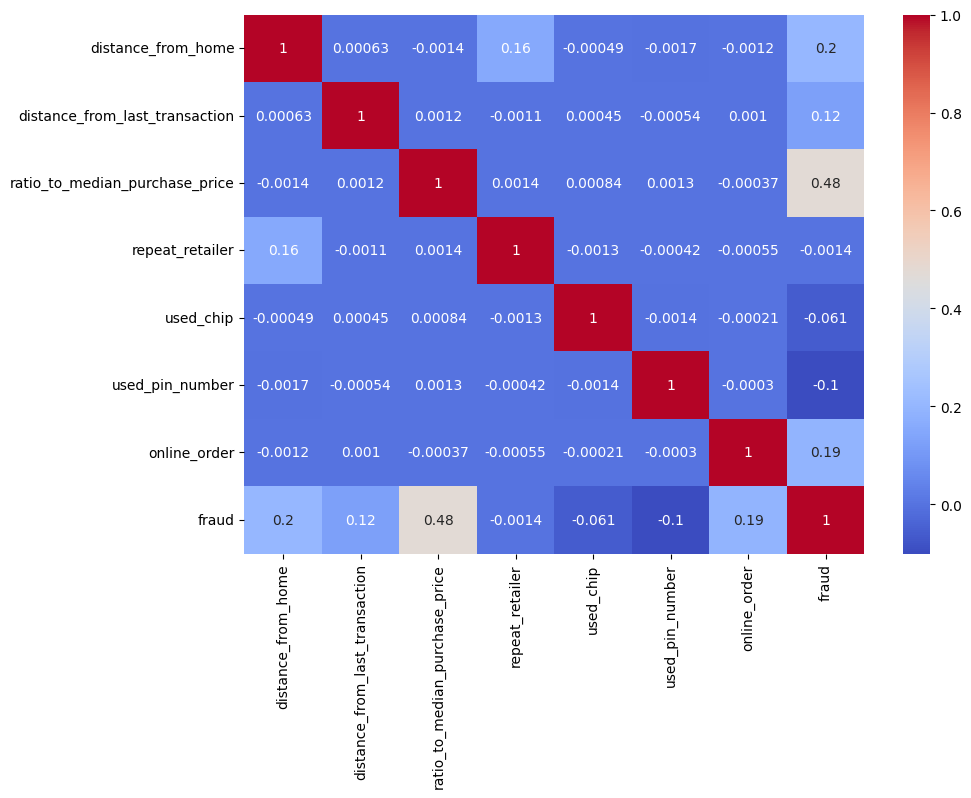

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

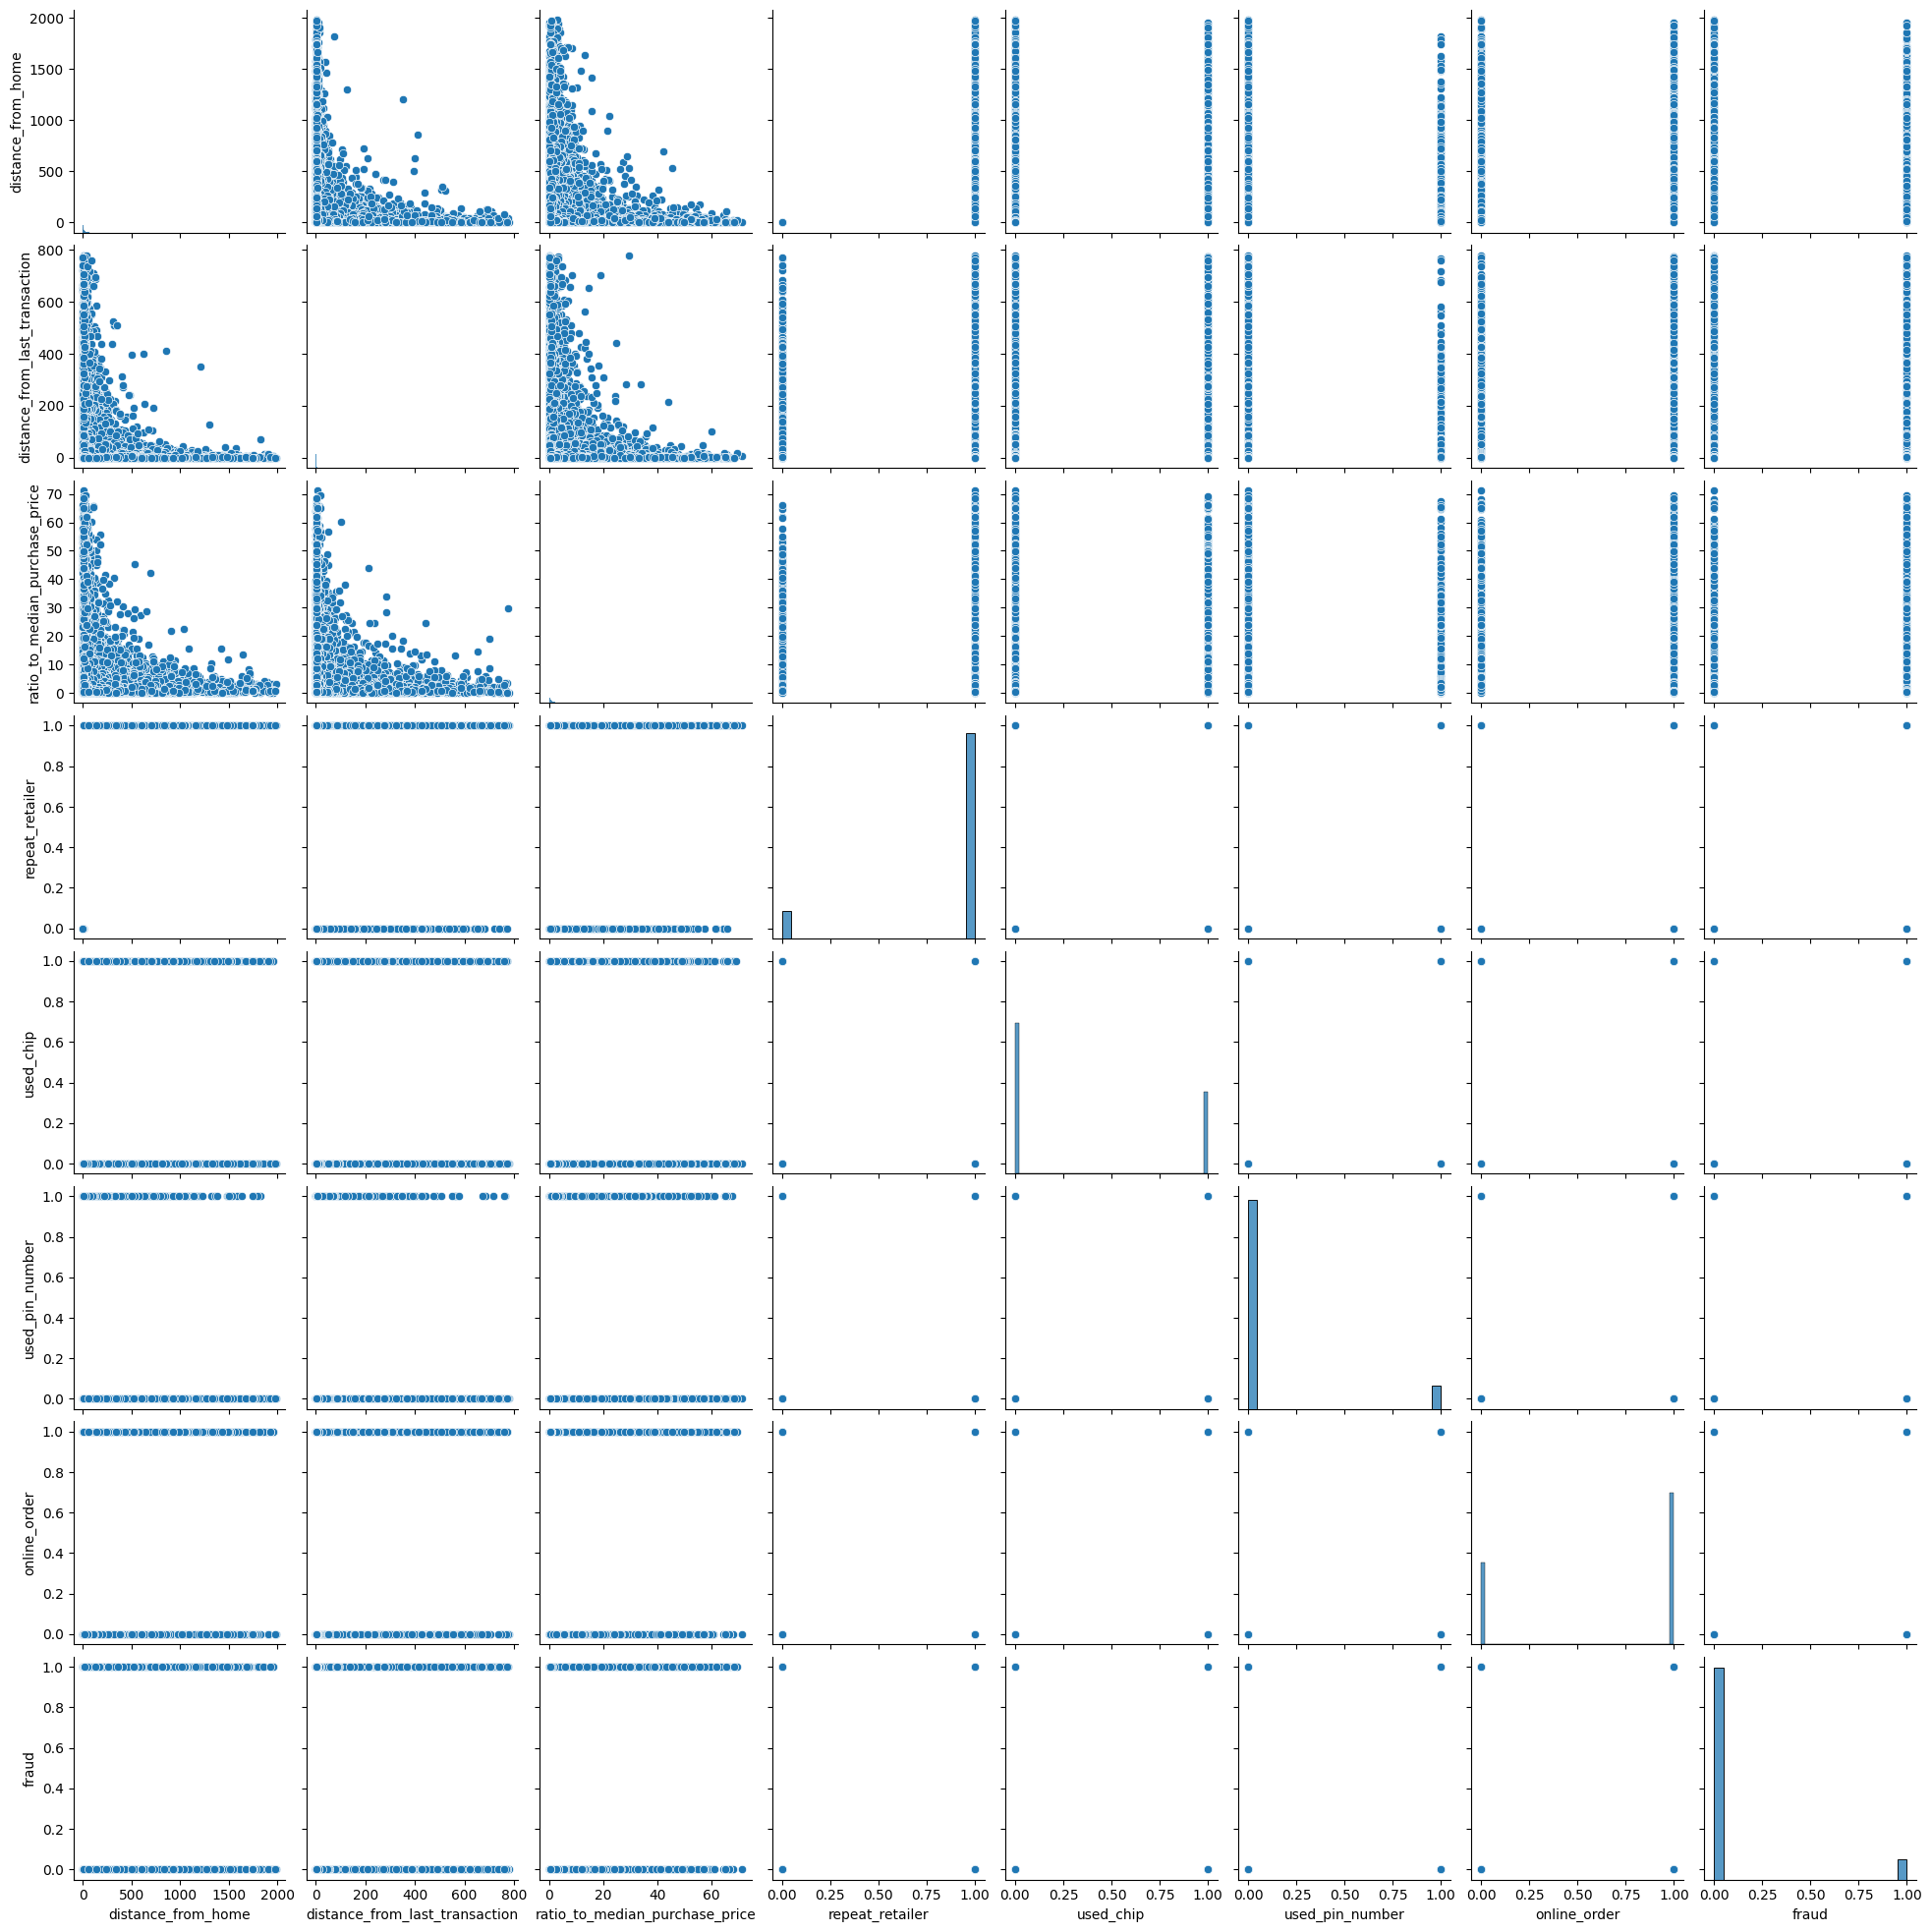

In [ ]:
sns.pairplot(df)
plt.show()

## Data Scaling and Partitioning

#### Establishing the independent and dependent variables

In [16]:
X = pd.DataFrame(df.iloc[:, 0:7].values)
y = df.iloc[: ,-1].values

sc = StandardScaler()
X = sc.fit_transform(X)

#### Split dataset into 3 portions

The dataset is split into 3 different datasets that will then be used to train each of the three models.

To effectively detect fraud, our foremost goal is to ensure an equitable distribution of positive fraud records across all three datasets. This is achieved by stratifying the split based on the target variable.

In [17]:
# Separate fraud and non-fraud records
fraud, no_fraud = df[df['fraud'] == 1], df[df['fraud'] == 0]

# Create 3 partitions of (mostly) equal size
df = shuffle(pd.concat([fraud, no_fraud]))
even_distr = int(df.shape[0]/3)
df1 = df.head(even_distr)
df2 = df.iloc[even_distr + 1 : (even_distr * 2) + 1]
df3 = df.tail(even_distr + 1)

# Display statistics
print(f'Amount of fraud records: {fraud.shape[0]}')
print(f'Amount of Non-fraud records: {no_fraud.shape[0]}')
print( f'Amount allocated to each dataset: {even_distr}')
print("Sizes of partitioned DataFrames: " + str(df1.shape) + ", " + str(df2.shape) + ", " + str(df3.shape))

Amount of fraud records: 87297
Amount of Non-fraud records: 912483
Amount allocated to each dataset: 333260
Sizes of partitioned DataFrames: (333260, 8), (333260, 8), (333261, 8)


## Classification Models

### Logistic Regression

#### Train/Test Split on Partition 1

In [4]:
X = pd.DataFrame(df1.iloc[:, 0:7].values)
y = df1.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)

print(f'Train Shape: {X_train.shape}, Test Shape: {X_test.shape}')

NameError: name 'df1' is not defined

#### Hyperparameter Tuning

In [20]:
logit = LogisticRegression(max_iter=3000, verbose=1, random_state=seed)

param_grid = {
    'C': [0.1, 0.2, 0.3, 0.4],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(estimator=logit, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best hyperparameter:', grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 285 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 280 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 288 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 281 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 280 seconds
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 255 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 262 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 262 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 262 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 255 seconds
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 284 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 275 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 276 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 280 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 277 seconds
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 255 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 255 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 278 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 251 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 245 seconds
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 285 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 283 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 273 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 275 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 282 seconds
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 254 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 266 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 264 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 259 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 264 seconds
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 293 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 292 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 292 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 292 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 295 seconds
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 271 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 269 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 273 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 272 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 282 seconds
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameter: {'C': 0.4, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9597391426113745


#### Base Logistic Regression Model

In [21]:
t_logit = LogisticRegression(random_state=seed)
t_logit.fit(X_train, y_train)
y_nw = t_logit.predict(X_test)

print(f'Recall: {recall_score(y_test,y_nw)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test,y_nw)}\n')
print(classification_report(y_test, y_nw))

Recall: 0.6127700564194303
Confusion Matrix:
[[75464   584]
 [ 2814  4453]]

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     76048
         1.0       0.88      0.61      0.72      7267

    accuracy                           0.96     83315
   macro avg       0.92      0.80      0.85     83315
weighted avg       0.96      0.96      0.96     83315



#### Tuned Logistic Regression model

In [22]:
best_logit = LogisticRegression(C=0.4, penalty='l1', solver='liblinear', random_state=seed)
best_logit.fit(X_train, y_train)
y_hat = best_logit.predict_proba(X_test)
y_scores = y_hat[:,1]
y_pred = [1 if prob > 0.4 else 0 for prob in y_scores]

print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

Recall: 0.7042796202009082
Confusion Matrix:
[[75232   816]
 [ 2149  5118]]

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     76048
         1.0       0.86      0.70      0.78      7267

    accuracy                           0.96     83315
   macro avg       0.92      0.85      0.88     83315
weighted avg       0.96      0.96      0.96     83315



#### ROC-AUC Curve

In [1]:
y_proba = best_logit.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

NameError: name 'best_logit' is not defined

### Artificial Neural Network (ANN)

#### Train/Test Split on Partition 2

In [ ]:
X = pd.DataFrame(df2.iloc[:, 0:7 ].values)
y = df2.iloc[: ,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)

#### Build Custom ANN Model with Keras

In [ ]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(hp.Choice('units',[32, 48, 64, 96, 128]), activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))
    model.compile(
        optimizer='SGD',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.Recall()]
    )
    return model

#### Hyperparameter Tuning
Hyper Parameter tuning to determine the amount of nuerons to be used in the hidden layer of the ANN.

In [ ]:
obj = keras_tuner.Objective('val_recall', direction='max')
tuner = keras_tuner.RandomSearch(build_model, objective=obj, max_trials=6)

In [ ]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

In [ ]:
tuner.results_summary()

#### K-fold Cross Validation

In [ ]:
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_collection = []

In [ ]:
for train, test in kfold.split(X, y):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(20, activation='relu') ,
      tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])

    model.compile(
        optimizer = 'SGD',
        loss = tf.keras.losses.MeanSquaredError(),
        metrics = [tf.keras.metrics.Recall()]
    )

    model.fit(X_train,y_train, epochs= 20)
    score = model.evaluate(X_test,y_test)
    scores_collection.append(score[1] * 100)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

print("%.2f%% (+/- %.2f%%)" % (np.mean(scores_collection), np.std(scores_collection)))

#### Model Evaluation

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))
model.compile(
    optimizer='SGD',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.Recall()]
)
model.fit(X_train, y_train, epochs=20)

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

#### ROC-AUC Curve

In [ ]:
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of ANN')
plt.legend(loc="lower right")
plt.show()

### Random Forest Classification

#### Train/Test Split on Partition 3

In [ ]:
X = pd.DataFrame(df3.iloc[:, 0:7].values)
y = df3.iloc[:, -1].values

# print number of fraud and non-fraud records in this dataframe
print(f'# of fraud records: {y[y==1].size}\n# of non-fraud records: {y[y==0].size}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)

# print stats
print(f'Train Shape: {X_train.shape}, Test Shape: {X_test.shape}')
print(f'Train Counts: {y_train.sum()}, Test Counts: {y_test.sum()}')

#### Model Training and Prediction

In [ ]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

print(f'Recall: {recall_score(y_test,y_hat)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test,y_hat)}\n\n')
print(classification_report(y_test, y_hat))

#### K-fold Cross Validation

In [ ]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)
scores_collection = []

In [ ]:
for x, (train, test) in enumerate(kfold.split(X, y)):
    rf = RandomForestClassifier(random_state=seed)
    rf.fit(X_test, y_test)
    y_hat = rf.predict(X_test)
    score = recall_score(y_test, y_hat)
    scores_collection.append(score * 100 )
    print(f'Iteration: {x + 1}, Recall: {score*100}')

print(f'Overall Recall: {np.mean(scores_collection)}, STD: {np.std(scores_collection)}')

#### ROC-AUC Curve

In [ ]:
probs = rf.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

## Conclusion